# AML Assignment 2 
<h3>Implement PCA from scratch</h3>

Done by: <b>Piyush Bhupendra Parsai</b><br>MIS#    :<b>712352029<b>

## <h3> Problem Statement:</h3>
Implement the PCA from scratch and apply it for dimensionality reduction and image denoising.

## <h3>Execution<h3>

Use the well-known <b><i>MNIST data set</b></i> that is commonly used for training various image processing systems and can be easily loaded from <b><i>keras.datasets</b></i>. The MNIST data set is a large data set of handwritten digits (from 0 to 9), containing 60000 gray-scale images for training and 10000 for testing, each image has 28x28 pixels with range of possible values from 0 to 255.

### <h3>import libraries<h3>

In [1]:
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

### <h3>Load the dataset </h3>

<b>Explore the dataset</b>

In [2]:
# Load mnist dataset from keras datasets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
# Print the testing data information
print(f'''x_test.shape = {x_test.shape}
x_test.min() = {x_test.min()}
x_test.max() = {x_test.max()}

y_test.shape = {y_test.shape}
y_test.min() = {y_test.min()}
y_test.max() = {y_test.max()}''')

x_test.shape = (10000, 28, 28)
x_test.min() = 0
x_test.max() = 255

y_test.shape = (10000,)
y_test.min() = 0
y_test.max() = 9


### <h3>Data Preparation</h3>

2. <b><i>Data Preparation</i></b>: For simplicity we will consider only the test data set and the first 2000 samples (in case of limited available memory). Re-scale the images to [0, 1] dividing them by 255. Vectorize each image xi ∈ R d and form a matrix X=[x1, . . . , xn] T ∈ R n×d. Remark that we will have d=784 and n=2000.

In [4]:
# Re-scale and vectorize the data
def PrepareData(input_data):
    # Divide input_data by 255 to rescale image between 0 and 1
    input_data = input_data / 255

    # Vectorize each image to form a matrix X of n:d with n = 2000 and d = 784 (28 ^ 2)
    vectorized_data = np.reshape(input_data, (2000, -1))
    return vectorized_data

In [5]:
# Get first 2000 samples from test data set
x_test_first_2000 = x_test[:2000]

# Prepare data
X = PrepareData(x_test_first_2000)
X.shape

(2000, 784)

### <h3>Eigendecomposition</h3>

3. Compute the eigendecomposition of the sample covariance matrix and use the eigenvalues to calculate the percentage of variance explained (given by the eigenvalues). Plot the cumulative sum of these percentages5 versus the number of components. (Comment. Hint: Use cumsum from Numpy to calculate the cumulative sum

In [6]:
def GetCenteredMetrix(input_metrix):
    # Get mean metrix from input
    mean_metrix = np.mean(input_metrix, axis=0)
    
    # Get centered data metrix from mean metrix
    centered_metrix = input_metrix - mean_metrix
    return centered_metrix

In [7]:
def GetEigenDecomposition(input_metrix):
    # Get covariance matrix from centered data matrix (sample covariance matrix) 
    cov_matrix = np.cov(input_metrix.T)
    
    # Perform eigendecomposition: Find eigenvectors and eigenvalues of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    return eigenvalues, eigenvectors

In [8]:
def GetExplainedVariance(eigenvalues):
    # Calculate the percentage of variance explained by each eigenvalue
    total_variance = np.sum(eigenvalues)
    explained_variance = (eigenvalues / total_variance) * 100
    
    # Print the percentage of variance explained by the first 20 eigenvalues
    print("Percentage of variance explained by the first 20 eigenvalues:")
    print(explained_variance[:20])
    
    return explained_variance

In [9]:
def PlotExplainedVariance(explained_variance, eigenvalues, title):
    # Discard the imagenary part from the complex numbers
    real_exp_var = np.real(explained_variance)
    
    # Calcumate cumulative sum of explained variance
    cum_sum_variance = np.cumsum(real_exp_var)
    
    # Plot the cumulative sum of explained variance versus the number of components
    plt.plot(range(1, len(eigenvalues) + 1), cum_sum_variance, marker='*')
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    plt.suptitle(title)
    plt.show()

Percentage of variance explained by the first 20 eigenvalues:
[9.71372672+7.56242159e-35j 7.55831069+5.88436690e-35j
 5.9102907 +4.60133493e-35j 4.99873231+3.89165994e-35j
 4.75510699+3.70199047e-35j 3.95306614+3.07757811e-35j
 3.24982652+2.53008541e-35j 2.80570003+2.18431989e-35j
 2.67051597+2.07907513e-35j 2.21475635+1.72425287e-35j
 2.16704285+1.68710652e-35j 2.12800827+1.65671695e-35j
 1.73552062+1.35115378e-35j 1.66025722+1.29255902e-35j
 1.57780127+1.22836463e-35j 1.45030392+1.12910420e-35j
 1.36355656+1.06156884e-35j 1.34398064+1.04632841e-35j
 1.19353084+9.29198820e-36j 1.18569366+9.23097344e-36j]


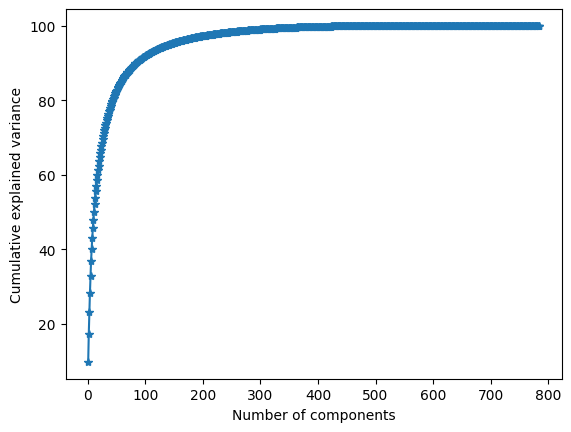

In [10]:
# Normalize the metrix
X_centered = GetCenteredMetrix(X)

# Get eigendecomposition of the sample covariance matrix
eigenvalues, eigenvectors = GetEigenDecomposition(X_centered)

# Calculate the explained variance given by eigenvalues
explained_variance = GetExplainedVariance(eigenvalues)

# Plot the cumulative sum of these percentages versus the number of components. 
PlotExplainedVariance(explained_variance, eigenvalues, "")

### <h3>Apply the PCA via Eigendecomposition</h3>

4. Apply the PCA via Eigendecomposition to reduce the dimensionality of the images for each p ∈ {50, 250, 500}. Compute the normalized reconstruction error in terms of the Frobenius norm, i.e. ep =||X − Xˆp||F/||X||F, where X denotes the input matrix, and Xˆp denotes the recovered matrix associated to each p. Visualize some recovered images and compare them with their corresponding original images.

In [11]:
def GetReducedFeatures(data, eigenvalues, count):
    # Sort the eigenvalues in descending order and select the top p eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1][:count]
    reduced_eigenvectors = eigenvectors[:, sorted_indices]

    # Project the data onto the top p eigenvectors
    reduced_data = np.dot(data, reduced_eigenvectors)
    
    # Print the shape of the reduced data
    print("Shape of the reduced data for p =", count, ":", reduced_data.shape)
    return reduced_data, reduced_eigenvectors

In [12]:
def PlotImages(data, title):
    plt.figure(figsize=(10, 2))
    for i in range(5):
      plt.subplot(1, 5, i + 1)
      plt.imshow(data[i].reshape(28, 28), cmap="gray")
      plt.xticks([])
      plt.yticks([])
       
    plt.suptitle(title)
    plt.show()

In [13]:
def PerformPCA(input_data, p, fro_norm_org, img_type):

    # Get eigen decomposition
    eigenvalues, eigenvectors = GetEigenDecomposition(X_centered)

    # Get data with reduced features (PCA)
    reduced_data, reduced_eigenvectors = GetReducedFeatures(input_data, eigenvalues, p)
    
    # Reconstruct the data using the reduced representation
    reconst_data = np.dot(reduced_data, reduced_eigenvectors.T)

    # Calculate the reconstruction error
    reconst_error = input_data - reconst_data
    fro_norm_error = np.linalg.norm(reconst_error, 'fro')

    # Calculate the normalized reconstruction error
    normalized_error = fro_norm_error / fro_norm_org
    print(f"Normalized Reconstruction Error = {normalized_error}\n")

    # Plot the original image
    PlotImages(input_data, img_type);

    # Plot reconstructed image
    reconst_data = reconst_data.astype(np.float32)
    PlotImages(reconst_data, "Reconstructed Images");

Shape of the reduced data for p = 50 : (2000, 50)
Normalized Reconstruction Error = 0.4177644109351586



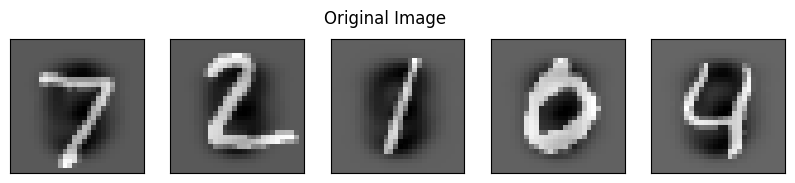

C:\Users\piyush_parsai\AppData\Local\Temp\ipykernel_22800\3110346738.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  reconst_data = reconst_data.astype(np.float32)


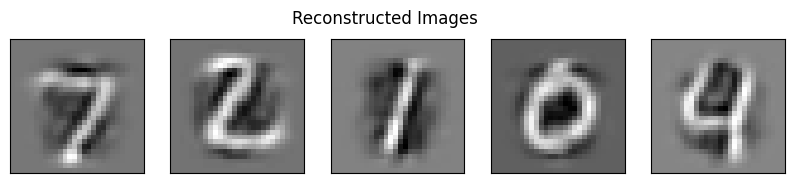

Shape of the reduced data for p = 250 : (2000, 250)
Normalized Reconstruction Error = 0.12825819283361614



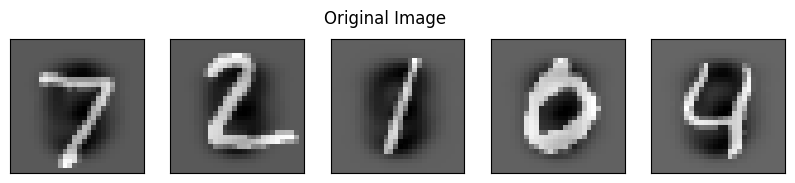

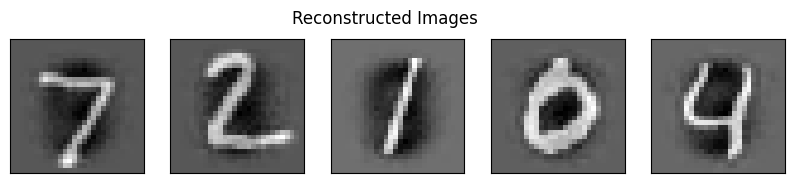

Shape of the reduced data for p = 500 : (2000, 500)
Normalized Reconstruction Error = 0.015557923411699794



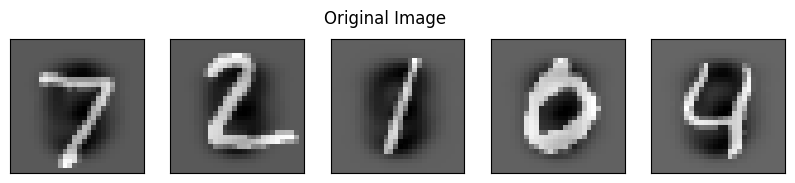

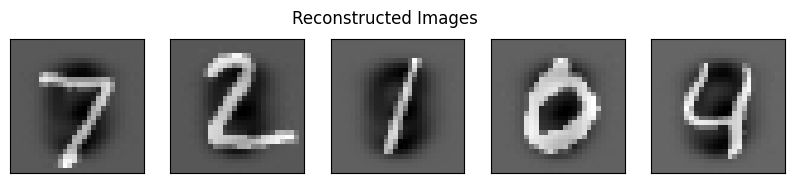

In [14]:
org_data = X_centered

# Get Frobenius norm of original data
fro_norm_org = np.linalg.norm(org_data, 'fro')

# define list for each p ∈ {50, 250, 500}
p_values = [50, 250, 500]

# Compute the normalized reconstruction error in terms of the Frobenius norm
for p in p_values:
    PerformPCA(org_data, p, fro_norm_org, "Original Image")

### <h3>Perform denoising</h3>

5. Now we will apply the PCA for image denoising. Considering the same input matrix, let’s add some Gaussian noise with zero mean and variance σ2 = 0.25. Visualize the corrupted images and compare them with their corresponding original images, you should obtain a similar figure to Fig. 1. Plot the cumulative explained variance versus the number of components, as in the first item. Compare it with the one obtained in the noiseless case and comment.

In [15]:
def GenerateNoisyData(input_data, mean, variance):
    # Generate Gaussian noise with given mean and variance
    noise = np.random.normal(0, np.sqrt(variance), input_data.shape)

    # Add noise to the original input
    noisy_input = input_data + noise
    X = PrepareData(noisy_input)
    centered_noisy = GetCenteredMetrix(X)

    # return noisy centered metrix
    return centered_noisy

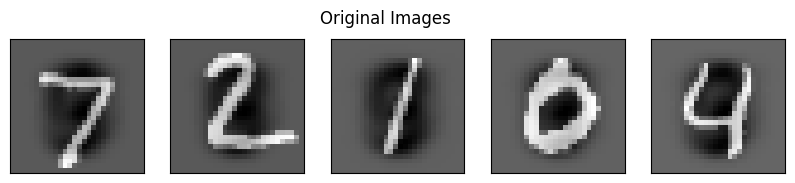

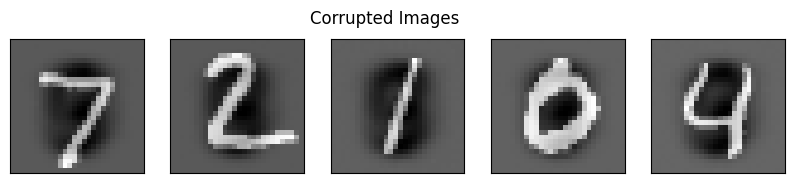

In [16]:
# Get the original image data
x_input = x_test[:2000]
X = PrepareData(x_input)
centered_org = GetCenteredMetrix(X)

# Generate noisy data using Gaussian noise with zero mean and variance 0.25
centered_noisy = GenerateNoisyData(x_input, 0, 0.25)

# Plot the original image and corrupted image
PlotImages(centered_org, "Original Images");

#centered_noisy = centered_noisy.astype(np.float32)
PlotImages(centered_noisy, "Corrupted Images");

Percentage of variance explained by the first 20 eigenvalues:
[9.71372672+7.56242159e-35j 7.55831069+5.88436690e-35j
 5.9102907 +4.60133493e-35j 4.99873231+3.89165994e-35j
 4.75510699+3.70199047e-35j 3.95306614+3.07757811e-35j
 3.24982652+2.53008541e-35j 2.80570003+2.18431989e-35j
 2.67051597+2.07907513e-35j 2.21475635+1.72425287e-35j
 2.16704285+1.68710652e-35j 2.12800827+1.65671695e-35j
 1.73552062+1.35115378e-35j 1.66025722+1.29255902e-35j
 1.57780127+1.22836463e-35j 1.45030392+1.12910420e-35j
 1.36355656+1.06156884e-35j 1.34398064+1.04632841e-35j
 1.19353084+9.29198820e-36j 1.18569366+9.23097344e-36j]


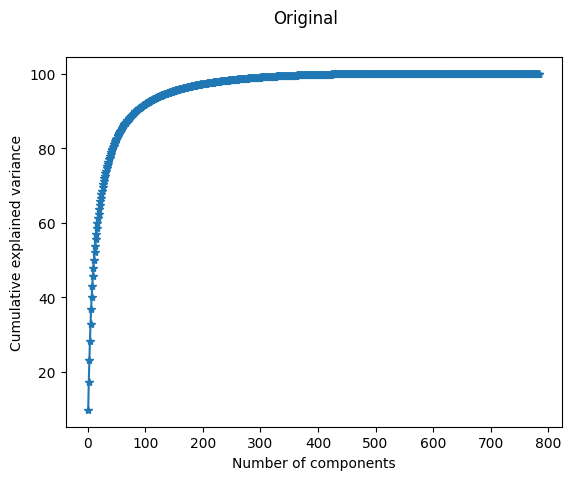

In [17]:
# Plot Explained Variance of origianl data to compare with noisy data
eigenvalues, eigenvectors = GetEigenDecomposition(centered_org)
explained_variance_org = GetExplainedVariance(eigenvalues)
PlotExplainedVariance(explained_variance_org, eigenvalues, "Original")

Percentage of variance explained by the first 20 eigenvalues:
[9.71312999 7.55753609 5.91039989 4.99876647 4.7545023  3.95308824
 3.24993435 2.80523327 2.67061271 2.2144734  2.16687763 2.12795652
 1.73553899 1.66016177 1.57773574 1.45025169 1.36351606 1.34380397
 1.19346474 1.18588002]


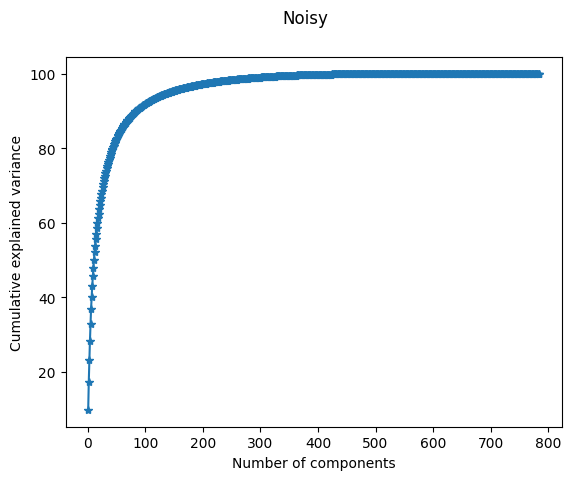

In [18]:
# Plot Explained Variance or noisy data
eigenvalues, eigenvectors = GetEigenDecomposition(centered_noisy)
explained_variance_noisy = GetExplainedVariance(eigenvalues)
PlotExplainedVariance(explained_variance_noisy, eigenvalues, "Noisy")

<B>Comment: The plot of explained variance of different components is same for original and noisy data.</B>

### <h3>Generate the noisy data</h3>

6. Generate the noisy data, as in the previous item, for each σ2 ∈ {0.15, 0.25, 0.50}.

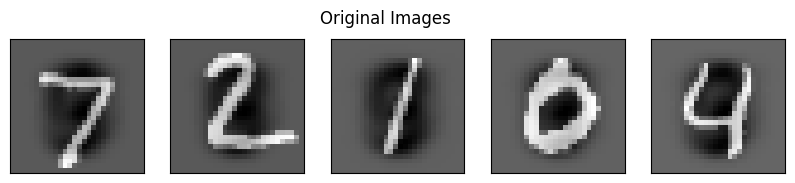

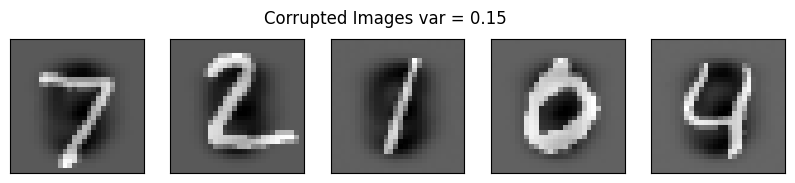

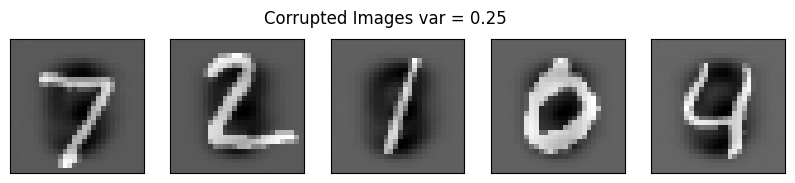

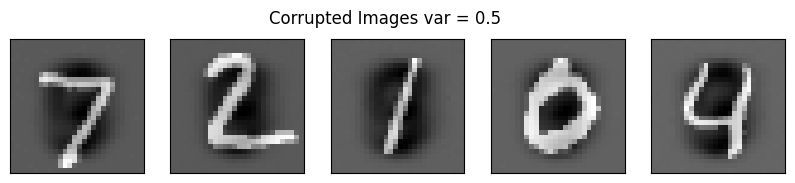

In [19]:

# Plot the original image and corrupted image
PlotImages(centered_org, "Original Images");

# List of σ2 ∈ {0.15, 0.25, 0.50}
v_values = [0.15, 0.25, 0.50]
noisy_data_list = []
for variance in v_values:
    # Generate noisy data with 0 mean and given variance
    centered_noisy = GenerateNoisyData(x_input, 0, variance)
    noisy_data_list.append((variance, centered_noisy))
    PlotImages(centered_noisy, f"Corrupted Images var = {variance}");


### <h3>Compare reconstruction of noisy input</h3>

7. Apply the PCA via Eigendecomposition for each σ2 and fixing p = 250. Visualize some recovered images and compare them with their corresponding noisy images. Compute the normalized reconstruction error in terms of the Frobenius norm, obtained for all values of σ2, with respect to the original images.

Shape of the reduced data for p = 250 : (2000, 250)
Normalized Reconstruction Error = 0.12838334709559363



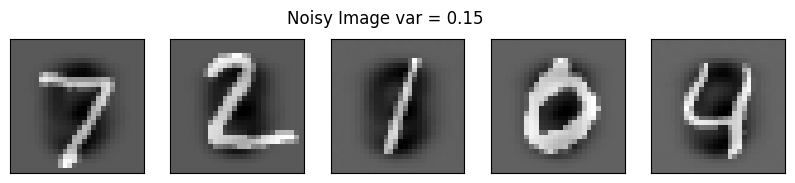

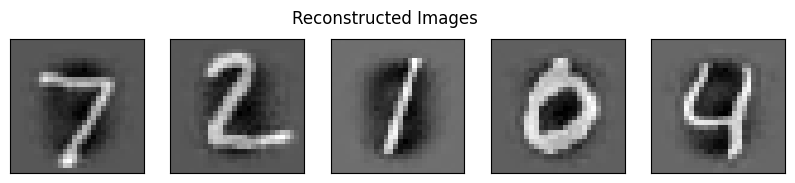

Shape of the reduced data for p = 250 : (2000, 250)
Normalized Reconstruction Error = 0.12845289189170245



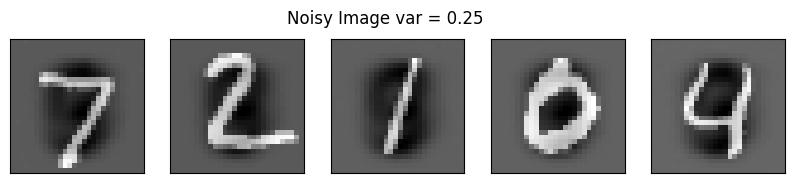

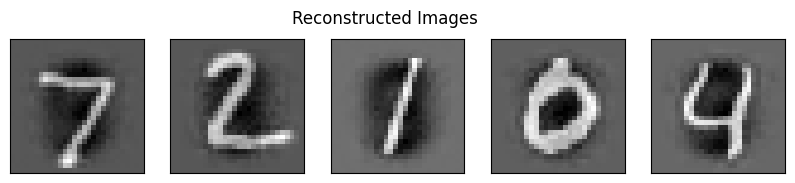

Shape of the reduced data for p = 250 : (2000, 250)
Normalized Reconstruction Error = 0.12860546315041999



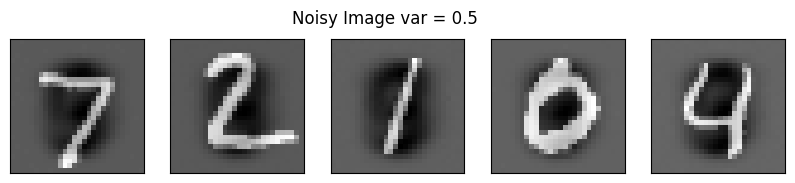

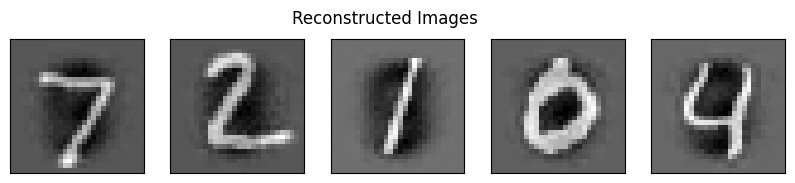

In [20]:
for data in noisy_data_list:
    fro_norm_data = np.linalg.norm(data[1], 'fro')
    PerformPCA(data[1], 250, fro_norm_data, f"Noisy Image var = {data[0]}")